In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from hydra.utils import instantiate
from hydra import initialize, compose
import hydra

import wandb

from data.dataManager import DataManager
from model.modelCreator import ModelCreator
from omegaconf import OmegaConf
from scripts.run import setup_model, load_model_instance

from utils.plots import vae_plots
from utils.rbm_plots import plot_rbm_histogram

import os
import re

In [38]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="config")
config=compose(config_name="config.yaml")
wandb.init(tags = [config.data.dataset_name], project=config.wandb.project, entity=config.wandb.entity, config=OmegaConf.to_container(config, resolve=True), mode='disabled')

In [39]:
if wandb.run is not None:
    print("yes")

yes


In [41]:
path = config.config_path
config = OmegaConf.load(path)
config

{'data': {'dataset_name': 'CaloChallenge2', 'path': '/fast_scratch_1/caloqvae/data/atlas_dataset2and3/dataset_2_1_filtered.hdf5', 'binning_path': '/fast_scratch_1/caloqvae/data/atlas_dataset2and3/binning_dataset_2.xml', 'relevantLayers': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], 'particle': 'electron', 'z': 45, 'r': 9, 'phi': 16, 'frac_val_dataset': 0.1, 'frac_train_dataset': 0.8, 'batch_size_tr': 512, 'batch_size_val': 1024, 'batch_size_test': 1024, 'num_workers': 8}, 'wandb': {'project': 'caloqvae', 'entity': 'caloqvae', 'mode': 'online'}, 'model': {'model_name': 'ae_separate', 'encoder': 'hierachicalencoder', 'encoderblock': 'CaloChallenge2', 'decoder': 'decoderhierachy0', 'decoder_input': [1208, 3368, 3368, 3368], 'decoder_output': [2160, 2160, 2160, 6480], 'mse_weight': 0.5, 'coefficient': 0.01, 'loss_coeff': {'ae_loss': 1.0, 'hit_loss': 1.0, 'entropy':

In [ ]:
def create_filenames_dict(config):
    pattern = r'\d+.pth$'
    prefix = config.run_path.split('files')[0] + 'files/'
    _fn = list(np.sort(os.listdir(prefix)))
    modelnames = [word for word in _fn if re.search(pattern, word)]
    confignames = [re.sub(r'\.pth$', '_config.yaml', name) for name in modelnames]

    idx = [int(name.split('_')[-1].split('.')[0]) for name in modelnames]
    filenames = {idx[i]: [modelnames[i], confignames[i]] for i in range(len(modelnames))}
    return filenames

In [59]:
filenames = create_filenames_dict(config)
for idx in np.sort(list(filenames.keys())):
    print(filenames[idx])

['ae_separate_0.pth', 'ae_separate_0_config.yaml']
['ae_separate_10.pth', 'ae_separate_10_config.yaml']
['ae_separate_20.pth', 'ae_separate_20_config.yaml']
['ae_separate_30.pth', 'ae_separate_30_config.yaml']
['ae_separate_40.pth', 'ae_separate_40_config.yaml']
['ae_separate_50.pth', 'ae_separate_50_config.yaml']
['ae_separate_60.pth', 'ae_separate_60_config.yaml']
['ae_separate_70.pth', 'ae_separate_70_config.yaml']
['ae_separate_80.pth', 'ae_separate_80_config.yaml']
['ae_separate_90.pth', 'ae_separate_90_config.yaml']
['ae_separate_100.pth', 'ae_separate_100_config.yaml']
['ae_separate_110.pth', 'ae_separate_110_config.yaml']
['ae_separate_120.pth', 'ae_separate_120_config.yaml']
['ae_separate_130.pth', 'ae_separate_130_config.yaml']
['ae_separate_140.pth', 'ae_separate_140_config.yaml']
['ae_separate_150.pth', 'ae_separate_150_config.yaml']
['ae_separate_160.pth', 'ae_separate_160_config.yaml']
['ae_separate_170.pth', 'ae_separate_170_config.yaml']
['ae_separate_180.pth', 'ae_sepa

In [54]:
filenames

{0: ['ae_separate_0.pth', 'ae_separate_0_config.yaml'],
 10: ['ae_separate_10.pth', 'ae_separate_10_config.yaml'],
 100: ['ae_separate_100.pth', 'ae_separate_100_config.yaml'],
 110: ['ae_separate_110.pth', 'ae_separate_110_config.yaml'],
 120: ['ae_separate_120.pth', 'ae_separate_120_config.yaml'],
 130: ['ae_separate_130.pth', 'ae_separate_130_config.yaml'],
 140: ['ae_separate_140.pth', 'ae_separate_140_config.yaml'],
 150: ['ae_separate_150.pth', 'ae_separate_150_config.yaml'],
 160: ['ae_separate_160.pth', 'ae_separate_160_config.yaml'],
 170: ['ae_separate_170.pth', 'ae_separate_170_config.yaml'],
 180: ['ae_separate_180.pth', 'ae_separate_180_config.yaml'],
 190: ['ae_separate_190.pth', 'ae_separate_190_config.yaml'],
 20: ['ae_separate_20.pth', 'ae_separate_20_config.yaml'],
 200: ['ae_separate_200.pth', 'ae_separate_200_config.yaml'],
 210: ['ae_separate_210.pth', 'ae_separate_210_config.yaml'],
 220: ['ae_separate_220.pth', 'ae_separate_220_config.yaml'],
 230: ['ae_separate_

In [3]:
new_model = False
if new_model:
    self = setup_model(config)
    # self.model = self.model.double()  # sets all model parameters to float64
else:
    self = load_model_instance(config.config_path)
    # self.model = self.model.double()


[22:30:04.332] INFO   data.dataManager                                  Loading other dataset: CaloChallenge2
[22:30:04.334] INFO   data.dataManager                                  Keys: ['incident_energies', 'showers']
[22:30:09.851] INFO   data.dataManager                                  dict_keys(['incident_energies', 'showers'])
[22:30:09.853] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f00b7f54350>: 79999 events, 157 batches
[22:30:09.854] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f00b7333500>: 10001 events, 10 batches
[22:30:09.854] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f00b7331820>: 9999 events, 10 batches
[22:30:09.854] INFO   model.modelCreator                                ::Creating Model
[22:30:10.570] INFO   dwave.cloud.client.base                           Fetching d

/home/jtoledo/CaloQuVAE


[22:30:11.334] INFO   scripts.run                                       Requesting GPUs. GPU list :[1]
[22:30:11.335] INFO   scripts.run                                       Main GPU : cuda:1
[22:30:11.499] INFO   scripts.run                                       CUDA available


cuda:1


[22:30:12.617] INFO   model.modelCreator                                Loading state


encoder._networks.0.seq1.0.conv.weight True
encoder._networks.0.seq1.0.conv.bias True
encoder._networks.0.seq1.1.weight True
encoder._networks.0.seq1.1.bias True
encoder._networks.0.seq1.2.weight True
encoder._networks.0.seq1.3.conv.weight True
encoder._networks.0.seq1.3.conv.bias True
encoder._networks.0.seq1.4.weight True
encoder._networks.0.seq1.4.bias True
encoder._networks.0.seq1.5.weight True
encoder._networks.0.seq1.6.conv.weight True
encoder._networks.0.seq1.6.conv.bias True
encoder._networks.0.seq1.7.weight True
encoder._networks.0.seq1.7.bias True
encoder._networks.0.seq1.8.weight True
encoder._networks.0.seq2.0.conv.weight True
encoder._networks.0.seq2.0.conv.bias True
encoder._networks.0.seq2.1.weight True
encoder._networks.0.seq2.1.bias True
encoder._networks.0.seq2.2.weight True
encoder._networks.0.seq2.3.conv.weight True
encoder._networks.0.seq2.3.conv.bias True
encoder._networks.0.seq2.4.weight True
encoder._networks.1.seq1.0.conv.weight True
encoder._networks.1.seq1.0.

[22:30:12.953] INFO   model.modelCreator                                Loading weights from file : /fast_scratch_1/caloqvae/jtoledo/wandb/run-20250713_203455-5z4zvttz/files/ae_separate_240.pth


Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _bce_loss
Loading weights for module =  encoder
Loading weights for module =  decoder
Loading weights for module =  prior


In [82]:
# config.model.decoder_input
# self.model.decoder
self.total_loss_dict = {}

In [12]:
with torch.no_grad():
    self.model.eval()
    self.model.training = True
    res_tr = {"post_logits" : [], "post_samples": [], "output_activations": [], "output_hits": [], "shower": [], "incidence_energy": []}
    for i, (x, x0) in enumerate(self.data_mgr.test_loader):
        # x, x0 = next(iter(self.data_mgr.val_loader))
        x = x.to(self.device)
        x0 = x0.to(self.device)
        x = self._reduce(x, x0)
        # Forward pass
        output = self.model((x, x0), self.beta, 0)
        for i,key in enumerate(res_tr.keys()):
            if key == "post_logits":
                res_tr[key].append(torch.cat(output[1],dim=1).cpu().numpy())
            elif key == "post_samples":
                res_tr[key].append(torch.cat(output[2],dim=1).cpu().numpy())
            elif key == "output_activations":
                res_tr[key].append(output[3].cpu().numpy())
            elif key == "output_hits":
                res_tr[key].append(output[4].cpu().numpy())
            elif key == "shower":
                res_tr[key].append(x.cpu().numpy())
            elif key == "incidence_energy":
                res_tr[key].append(x0.cpu().numpy())
    
    self.model.training = False
    res_val = {"post_logits" : [], "post_samples": [], "output_activations": [], "output_hits": [], "shower": [], "incidence_energy": []}
    for i, (x, x0) in enumerate(self.data_mgr.test_loader):
        # x, x0 = next(iter(self.data_mgr.val_loader))
        x = x.to(self.device)
        x0 = x0.to(self.device)
        x = self._reduce(x, x0)
        # Forward pass
        output = self.model((x, x0), self.beta, 0)
        for i,key in enumerate(res_tr.keys()):
            if key == "post_logits":
                res_val[key].append(torch.cat(output[1],dim=1).cpu().numpy())
            elif key == "post_samples":
                res_val[key].append(torch.cat(output[2],dim=1).cpu().numpy())
            elif key == "output_activations":
                res_val[key].append(output[3].cpu().numpy())
            elif key == "output_hits":
                res_val[key].append(output[4].cpu().numpy())
            elif key == "shower":
                res_val[key].append(x.cpu().numpy())
            elif key == "incidence_energy":
                res_val[key].append(x0.cpu().numpy())

In [15]:
for key in res_tr.keys():
    res_tr[key] = np.concatenate(res_tr[key], axis=0)
    res_val[key] = np.concatenate(res_val[key], axis=0)

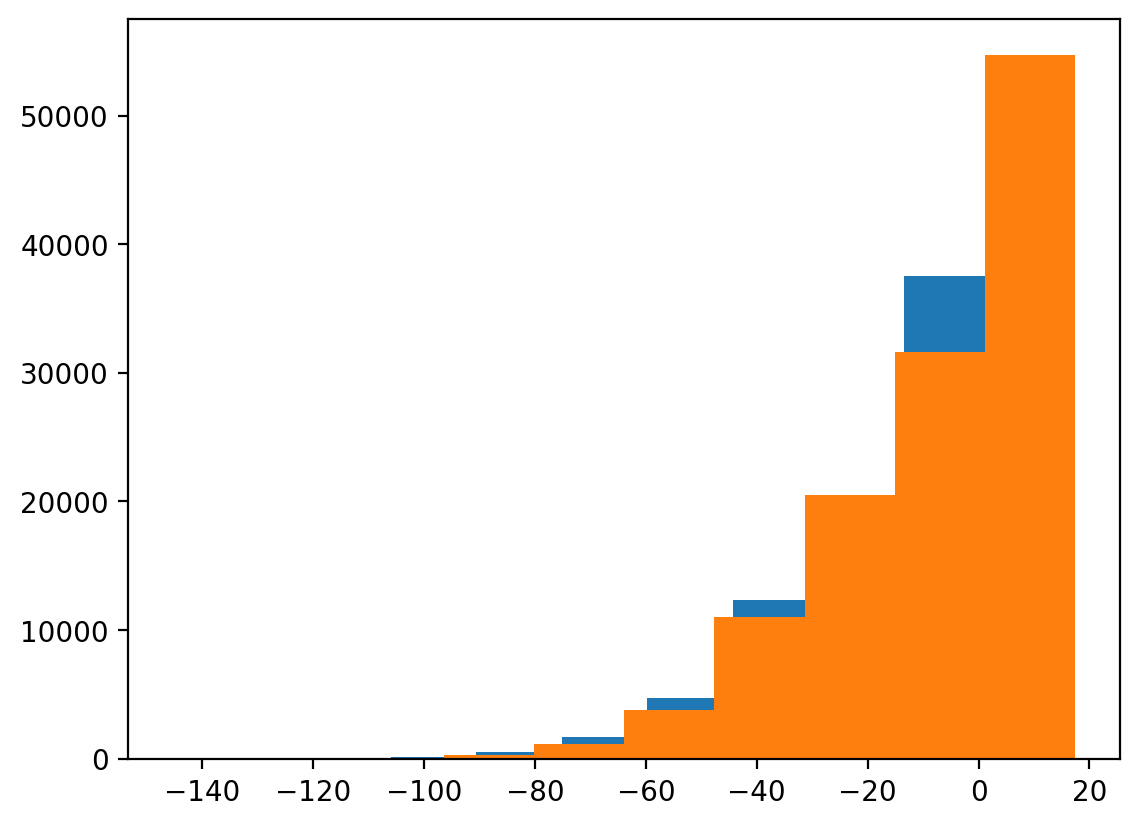

In [24]:
plt.hist(res_tr["output_hits"][1:20,:].reshape(-1))
plt.hist(res_val["output_hits"][1:20,:].reshape(-1))
plt.show()
# res_tr["output_hits"].shape

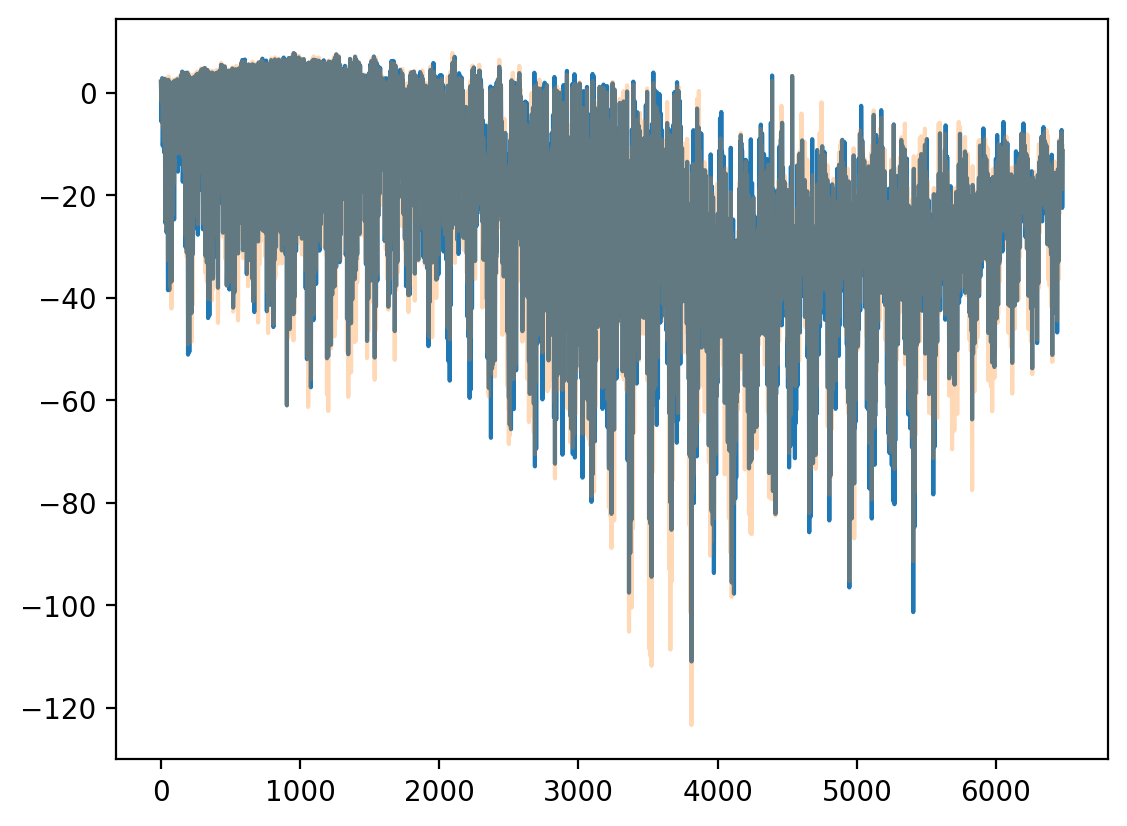

In [32]:
idx=2001
plt.plot(res_tr["output_hits"][idx,:].reshape(-1))
plt.plot(res_val["output_hits"][idx,:].reshape(-1), alpha=0.3)